<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/conv_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from IPython import display

In [4]:
!pip install wandb

display.clear_output()

In [5]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb

from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm_notebook

In [6]:
%matplotlib inline

In [7]:
cifar_means = (0.49139968, 0.48215827, 0.44653124)
cifar_stds = (0.24703233, 0.24348505, 0.26158768)

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_means, cifar_stds)])

In [9]:
BATCH_TRAIN = 4
BATCH_TEST = 4
WRKRS = 2
TOWHERE = './data'
SEED = 42
EPOCHS = 3
LR = 1e-4

In [77]:
WNB_FLAG = True
API_KEY = ''
WNB_PROJECT = 'custom_CIFAR10'
WNB_LOGIN = 'dimildizio'

In [11]:
def log_wnb(model, conf):
  if WNB_FLAG:
    os.environ["WANDB_API_KEY"] = API_KEY
    wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, reinit=True, config=conf)
    wandb.watch(model, log='all')

def log_step(name, iloss, accuracy):
  if WNB_FLAG:
      wandb.log({name+'_loss':iloss, 
          name+'_accuracy': accuracy})


In [12]:
trainset = datasets.CIFAR10(root = TOWHERE, train=True, download=True, transform = transform)
testset = datasets.CIFAR10(root = TOWHERE, train=False, download=True, transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_TRAIN, num_workers = WRKRS, pin_memory = True, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_TEST, num_workers = WRKRS, pin_memory = True, shuffle = False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43060268.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
print('Train:', train_loader.dataset.data.shape)
print('Test:', test_loader.dataset.data.shape)

Train: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [15]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEDD'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.determetistic = True
  torch.backends.cudnn.benchmark = False

seed_all(SEED)

In [16]:
def getnum():
  return np.random.randint(low=0, high=10000)

In [17]:
class MyCIFAR(nn.Module):
  def __init__(self):
    super(MyCIFAR, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def convolute(self, conv, x):
    convd = conv(x)
    activated = F.relu(convd)
    pooled = self.pool(activated)
    return pooled

  def fcs(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x


  def forward(self, x):
    x = self.convolute(self.conv1, x)
    x = self.convolute(self.conv2, x)
    x = self.flatten(x)
    x = self.fcs(x)
    return x


In [18]:
def getloss(netparam, y_pred, y, loss_fn, logitnorm = False):
  if logitnorm:
    y_pred = F.softmax(y_pred, dim=1)
    loss = loss_fn(y_pred, y)
    l2reg = torch.tensor(0.)
    for p in netparam:
      l2reg += torch.norm(p,p=2)
    loss += 0.001*l2reg
  else:
    loss = loss_fn(y_pred, y)
  return loss

In [59]:
def train(net, optimizer, loss_fn, normalize=False, epochs=EPOCHS, scheduler=False):
  net.train()
  for epoch in range(epochs):
    curloss = 0.0
    correct=0
    total_samples = 0

    for i, batch in enumerate(tqdm_notebook(train_loader)):
      optimizer.zero_grad()
      X, y = batch
      y_pred = net(X)

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
      total_samples += y.size(0)

      loss = getloss(net.parameters(), y_pred, y, loss_fn, normalize)
      loss.backward()
      optimizer.step()
      curloss += loss.item()

      if not (i % int(train_loader.dataset.data.shape[0] / BATCH_TRAIN / 10)):
        print(f'Epoch: {epoch+1}, loss: {round(curloss, 3)}')
        curloss = 0.0
    log_step('train', loss, correct / total_samples)
    if scheduler:
      scheduler.step()    #should possibly be after optimizer for the sake of the first iteration      

In [58]:
def eval_me(net):
  net.eval()
  iloss = nn.CrossEntropyLoss()
  class_correct = [0]*10
  class_total = [0]*10
  correct=0
  total_samples = 0
  total_loss = 0.0

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      y_pred = net(images)
      
      loss = iloss(y_pred, labels)
      total_loss +=loss.item()

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct+= pred.eq(labels.view_as(pred)).sum().item()
      total_samples += labels.size(0)

      _, predicted = torch.max(y_pred,1)
      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

  results = []
  for i in range(10):
    result_i = 100 * class_correct[i] / class_total[i]
    results.append(result_i)
    print(f'Accuracy: {classes[i]}: {result_i}%')

  acc =  correct / total_samples
  log_step('test', total_loss, acc)
  

In [21]:
def visualize_result(idx, net):
    img = test_loader.dataset.data[idx]
    plt.imshow(img)
    
    image = transform(img)  
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')


In [69]:
def get_watch(net, optimizer=optim.Adam, lr=LR, epoch = EPOCHS, scheduler=False, normalize = False):
  paramdict = {'epochs':epoch, 'train_batch':BATCH_TRAIN, 'num_workers':WRKRS, 
              'lr':lr, 'seed':SEED, 'classes':10}
  net = net()
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = optimizer(net.parameters(), lr=lr)
  if scheduler:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

  log_wnb(net, paramdict)

  train(net, optimizer, loss_fn, epochs=epoch, scheduler=scheduler, normalize=normalize)
  eval_me(net)
  if WNB_FLAG:
    wandb.finish()
  return net

In [67]:
get_watch(MyCIFAR, epoch=5, lr=1e-3, normalize=True, scheduler=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-59-52913d69420a>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.32
Epoch: 1, loss: 2819.463
Epoch: 1, loss: 2760.595
Epoch: 1, loss: 2754.203
Epoch: 1, loss: 2720.843
Epoch: 1, loss: 2707.169
Epoch: 1, loss: 2696.71
Epoch: 1, loss: 2698.364
Epoch: 1, loss: 2673.632
Epoch: 1, loss: 2700.639


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 1.566
Epoch: 2, loss: 2661.498
Epoch: 2, loss: 2665.699
Epoch: 2, loss: 2652.762
Epoch: 2, loss: 2641.695
Epoch: 2, loss: 2622.919
Epoch: 2, loss: 2620.237
Epoch: 2, loss: 2624.003
Epoch: 2, loss: 2603.706
Epoch: 2, loss: 2615.547


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.989
Epoch: 3, loss: 2585.814
Epoch: 3, loss: 2555.997
Epoch: 3, loss: 2557.978
Epoch: 3, loss: 2574.266
Epoch: 3, loss: 2553.762
Epoch: 3, loss: 2560.905
Epoch: 3, loss: 2553.0
Epoch: 3, loss: 2548.848
Epoch: 3, loss: 2545.986


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 1.766
Epoch: 4, loss: 2534.502
Epoch: 4, loss: 2508.613
Epoch: 4, loss: 2507.686
Epoch: 4, loss: 2515.27
Epoch: 4, loss: 2519.047
Epoch: 4, loss: 2509.324
Epoch: 4, loss: 2501.115
Epoch: 4, loss: 2493.102
Epoch: 4, loss: 2505.07


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 1.987
Epoch: 5, loss: 2481.606
Epoch: 5, loss: 2495.867
Epoch: 5, loss: 2484.292
Epoch: 5, loss: 2492.293
Epoch: 5, loss: 2496.655
Epoch: 5, loss: 2496.341
Epoch: 5, loss: 2496.34
Epoch: 5, loss: 2480.741
Epoch: 5, loss: 2495.524
Accuracy: plane: 51.1%
Accuracy: car: 62.5%
Accuracy: bird: 26.9%
Accuracy: cat: 35.0%
Accuracy: deer: 28.7%
Accuracy: dog: 41.9%
Accuracy: frog: 63.8%
Accuracy: horse: 56.0%
Accuracy: ship: 53.0%
Accuracy: truck: 57.4%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,█▁▅▅▃
test_accuracy,0.4763
test_loss,14376.69492
train_accuracy,0.4993
train_loss,1.9911


In [ ]:
net = MyCIFAR()
train(net, optim.Adam(net.parameters(), lr=LR, weight_decay=0.001), nn.CrossEntropyLoss(), normalize=True)
eval_me(net)

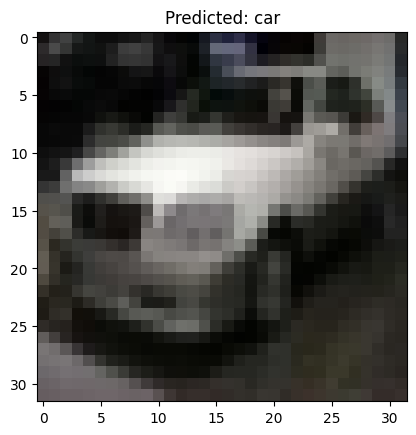

In [62]:
visualize_result(getnum(), net)

### Conditions: baseline\custom\logitnorm

> Batchsize:4\10\10

> Start loss: ~900\1100\1150

> End loss: ~400\760\1040


>>Accuracy: plane: 51.6% \ 62.1% \ 61.4%

>>Accuracy: car: 63.7% \ 56.1%  \ 50%

>>Accuracy: bird: 34.6% \ 44.2% \ 15.7%

>>Accuracy: cat: 53.8% \ 23.4% \ 17.8%

>>Accuracy: deer: 42.4% \ 37.5% \ 31.8%

>>Accuracy: dog: 0.0% \ 45.2% \ 22.7%

>>Accuracy: frog: 74.2% \ 71.9% \ 67.5%

>>Accuracy: horse: 66.9% \61.1% \ 52.3%

>>Accuracy: ship: 69.3% \ 0.0% \ 0.0%

>>Accuracy: truck: 55.8% \ 66.5% \ 64.5%


On this particular model looks like smaller batchsize (4) works better compared to larger (10). Also we've tested Alpha's logitnorm (used to fight overfitting) but in our case it worked worse even though it had been stated that l2 regularization and normalization of y_pred before putting it into loss function won't worsen the result.

Lets count the size for inputs one more time

1. Input image has 3 channels $32*32 = 32*32*3 =3072$ so the size is 3072
2. We retain the channels and calculate output size for **Width** and **Height** for first convolutions that is $Width^{out} = \frac{32-5 + 2*0}{1}+1 =28$ and $Height^{out} = \frac{32-5 + 2*0}{1}+1 =28$ 
3. We specified that or **out_channels=6** and **filter=5** so we've applied **six 5x5** filters to the image and resulted in **6(channels) * 28(width) * 28(height)** output
4. Apply max pooling stride=2 kernel=2 which lowers the dimensions to **6x14x14=1176**
5. For next convolution the out_channels=16 kernel=5 so for input 14x14 we take $Width^{out}=\frac{14-5+2*0}{1}+1=10$ and $Height^{out}=\frac{14-5+2*0}{1}+1=10$
6. The output is **16x10x10**
7. We dont do the pooling here and go straight to conv3
8. Third convolution makes **out_channels=32, kernel=5 for 10x10** input we get $Width^{out}=\frac{10-5+2*0}{1}+1=6$ and $Height^{out}=\frac{10-5+2*0}{1}+1=6$
9. And the output is **32x6x6**
10. Max pooling for stride=2 filter=2 makes it **32x3x3=288**
11. We perform the flattening which makes it **(288,)**
12. And the input size on the first fully-connected layer is **288** in our case
13. **288 -> 120 -> 84 -> 10** classes on output

In [27]:
class AnotherConv(nn.Module):
  def __init__(self):
    super(AnotherConv, self).__init__()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size = 5)

    self.fc1 = nn.Linear(288, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(self.conv3(F.relu(self.conv2(x))))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [36]:
net1 = AnotherConv()
train(net1, optim.Adam(net1.parameters(), lr=1e-3), nn.CrossEntropyLoss())
eval_me(net1)

<ipython-input-15-cb002da5c25a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.318
Epoch: 1, loss: 2565.076
Epoch: 1, loss: 2322.286
Epoch: 1, loss: 2154.457
Epoch: 1, loss: 2062.91
Epoch: 1, loss: 2006.557
Epoch: 1, loss: 2015.204
Epoch: 1, loss: 1947.698
Epoch: 1, loss: 1905.088
Epoch: 1, loss: 1911.026


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 1878.941
Epoch: 2, loss: 1818.858
Epoch: 2, loss: 1828.221
Epoch: 2, loss: 1803.59
Epoch: 2, loss: 1820.035
Epoch: 2, loss: 1781.869
Epoch: 2, loss: 1790.227
Epoch: 2, loss: 1753.081
Epoch: 2, loss: 1764.283
Epoch: 2, loss: 1731.724


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1766.893
Epoch: 3, loss: 1660.189
Epoch: 3, loss: 1692.968
Epoch: 3, loss: 1643.979
Epoch: 3, loss: 1643.52
Epoch: 3, loss: 1660.219
Epoch: 3, loss: 1647.188
Epoch: 3, loss: 1643.849
Epoch: 3, loss: 1688.427
Epoch: 3, loss: 1638.0


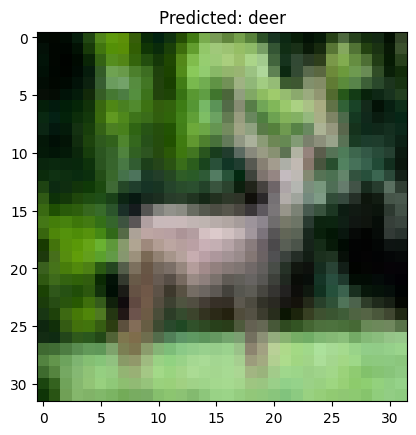

In [65]:
visualize_result(getnum(), net1)

In [28]:
get_watch(AnotherConv)

wandb: Currently logged in as: dimildizio. Use `wandb login --relogin` to force relogin


<ipython-input-20-f1b2d4f9d3ec>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.288
Epoch: 1, loss: 2665.05
Epoch: 1, loss: 2397.094
Epoch: 1, loss: 2322.207
Epoch: 1, loss: 2238.885
Epoch: 1, loss: 2178.665
Epoch: 1, loss: 2136.635
Epoch: 1, loss: 2081.692
Epoch: 1, loss: 2054.644
Epoch: 1, loss: 2010.059


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 2.154
Epoch: 2, loss: 1946.605
Epoch: 2, loss: 1926.979
Epoch: 2, loss: 1874.823
Epoch: 2, loss: 1867.327
Epoch: 2, loss: 1853.559
Epoch: 2, loss: 1864.734
Epoch: 2, loss: 1830.308
Epoch: 2, loss: 1836.434
Epoch: 2, loss: 1792.133


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.205
Epoch: 3, loss: 1738.1
Epoch: 3, loss: 1740.495
Epoch: 3, loss: 1713.25
Epoch: 3, loss: 1732.629
Epoch: 3, loss: 1712.488
Epoch: 3, loss: 1680.058
Epoch: 3, loss: 1726.702
Epoch: 3, loss: 1708.241
Epoch: 3, loss: 1660.639
Accuracy: plane: 47.2%
Accuracy: car: 52.9%
Accuracy: bird: 31.4%
Accuracy: cat: 37.0%
Accuracy: deer: 42.9%
Accuracy: dog: 54.7%
Accuracy: frog: 59.4%
Accuracy: horse: 58.0%
Accuracy: ship: 67.3%
Accuracy: truck: 65.1%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▆█
train_loss,▂█▁
test_accuracy,0.5159
test_loss,3394.41108
train_accuracy,0.509
train_loss,0.83124


In [46]:
get_watch(AnotherConv, optimizer = optim.Adagrad, lr = 1e-2, epoch=5)

<ipython-input-20-f1b2d4f9d3ec>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.294
Epoch: 1, loss: 2460.085
Epoch: 1, loss: 2107.014
Epoch: 1, loss: 1998.566
Epoch: 1, loss: 1948.608
Epoch: 1, loss: 1889.358
Epoch: 1, loss: 1816.386
Epoch: 1, loss: 1822.74
Epoch: 1, loss: 1780.584
Epoch: 1, loss: 1760.877


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 2.233
Epoch: 2, loss: 1718.094
Epoch: 2, loss: 1707.045
Epoch: 2, loss: 1702.552
Epoch: 2, loss: 1646.869
Epoch: 2, loss: 1653.678
Epoch: 2, loss: 1652.63
Epoch: 2, loss: 1640.807
Epoch: 2, loss: 1580.314
Epoch: 2, loss: 1608.825


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.444
Epoch: 3, loss: 1563.306
Epoch: 3, loss: 1579.371
Epoch: 3, loss: 1547.0
Epoch: 3, loss: 1516.68
Epoch: 3, loss: 1537.63
Epoch: 3, loss: 1580.485
Epoch: 3, loss: 1561.958
Epoch: 3, loss: 1537.695
Epoch: 3, loss: 1506.893


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.711
Epoch: 4, loss: 1473.747
Epoch: 4, loss: 1500.244
Epoch: 4, loss: 1459.837
Epoch: 4, loss: 1462.216
Epoch: 4, loss: 1495.811
Epoch: 4, loss: 1454.121
Epoch: 4, loss: 1492.135
Epoch: 4, loss: 1433.397
Epoch: 4, loss: 1452.316


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.165
Epoch: 5, loss: 1402.342
Epoch: 5, loss: 1409.726
Epoch: 5, loss: 1404.268
Epoch: 5, loss: 1437.929
Epoch: 5, loss: 1450.278
Epoch: 5, loss: 1443.647
Epoch: 5, loss: 1435.36
Epoch: 5, loss: 1426.902
Epoch: 5, loss: 1387.309
Accuracy: plane: 61.9%
Accuracy: car: 68.7%
Accuracy: bird: 40.2%
Accuracy: cat: 35.1%
Accuracy: deer: 49.5%
Accuracy: dog: 52.4%
Accuracy: frog: 58.2%
Accuracy: horse: 70.6%
Accuracy: ship: 65.4%
Accuracy: truck: 70.8%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇█
train_loss,▂▁▆█▇
test_accuracy,0.5728
test_loss,2960.42866
train_accuracy,0.59242
train_loss,1.70425


#### Let's try a bit more sophisticated CNN with bottlenecks (usually filters with 1->3->1-> layers)

1. Input is **3x32x32**
2. con1 is in channels 3 out 8, padding=0, stride=1, kernel 5 - large to catch global patterns. So the dimensions are is $W^{out}=\frac{32-5+0*2}{1}+1=28$ $H^{out}=\frac{32-5+0*2}{1}+1=28$ and result is **8x28x28**
3. After every **activation** we're using **batch norm** - normalize the values in batch by $$result=(\frac{val-mean}{std}+β) * {γ}$$  - elementvise subtract mean, divide by std, add **shift** and multiply by **scale**, which are **different for each channel** - it makes the net faster, prevents changing the distribution and lowers dependance on previous layer, regularazies by adding some noise reducing overfitting and improving generalization, and it allows higher LR. So awesurm!
4. apply pooling with stride 2 and kernel 2 which makes it **8x14x14**
5. Bottleneck. First step with kernel=1 In_channels=8, out=16. dimensions **16x14x14** add **Batch norm too** no pooling
6. Second step of bottleneck. Kernel=3. In_channels 16, out=16. dimensions are **16x12x12** Add **Batchnorm**. Pooling makes it **16x6x6**
7. Last step of bottleneck. Kernel=1. In channels 16, out 32. **Batchnorm**. dimensions **32x6x6**
8. One more convolution layer kernel=3 makes it **32x4x4** add **Batchnorm**
9. **Flatten** it to **512** before putting it all to fully connected layer.
10. **fc 512-> 128**, activate and use **Dropout** 0.2
11. last fc layer return one of **10 classes**. no activation - is our result.



In [54]:
class OneMoreConv(nn.Module):
  def __init__(self):
    super(OneMoreConv, self).__init__()
    self.flatten = nn.Flatten()
    self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
    self.dropout = nn.Dropout(p=0.2)

    self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
    self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1)
    self.conv_3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
    self.conv_4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1)
    self.conv_5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

    self.bn_1 = nn.BatchNorm2d(8)
    self.bn_2 = nn.BatchNorm2d(16)
    self.bn_3 = nn.BatchNorm2d(16)
    self.bn_4 = nn.BatchNorm2d(32)
    self.bn_5 = nn.BatchNorm2d(32)

    self.fc_1 = nn.Linear(4*4*32, 128)
    self.fc_2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.bn_1(F.relu(self.conv_1(x)))
    x = self.pool(x)
    x = self.bn_2(F.relu(self.conv_2(x)))
    x = self.bn_3(F.relu(self.conv_3(x)))
    x = self.pool(x)
    x = self.bn_4(F.relu(self.conv_4(x)))
    x = self.bn_5(F.relu(self.conv_5(x)))
    x = self.flatten(x)
    x = F.relu(self.fc_1(x))
    x = self.dropout(x)
    x = self.fc_2(x)
    return x

In [55]:
get_watch(OneMoreConv, lr=4e-4, epoch=5)

<ipython-input-20-f1b2d4f9d3ec>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.207
Epoch: 1, loss: 2372.246
Epoch: 1, loss: 2162.26
Epoch: 1, loss: 2047.539
Epoch: 1, loss: 1961.904
Epoch: 1, loss: 1930.385
Epoch: 1, loss: 1866.893
Epoch: 1, loss: 1835.212
Epoch: 1, loss: 1812.654
Epoch: 1, loss: 1745.843


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 1.364
Epoch: 2, loss: 1618.011
Epoch: 2, loss: 1628.37
Epoch: 2, loss: 1619.887
Epoch: 2, loss: 1617.206
Epoch: 2, loss: 1564.345
Epoch: 2, loss: 1569.011
Epoch: 2, loss: 1568.128
Epoch: 2, loss: 1554.59
Epoch: 2, loss: 1541.94


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.293
Epoch: 3, loss: 1450.987
Epoch: 3, loss: 1447.751
Epoch: 3, loss: 1457.092
Epoch: 3, loss: 1400.551
Epoch: 3, loss: 1383.984
Epoch: 3, loss: 1407.894
Epoch: 3, loss: 1431.662
Epoch: 3, loss: 1402.02
Epoch: 3, loss: 1411.518


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.936
Epoch: 4, loss: 1305.117
Epoch: 4, loss: 1316.87
Epoch: 4, loss: 1307.19
Epoch: 4, loss: 1287.482
Epoch: 4, loss: 1340.522
Epoch: 4, loss: 1319.548
Epoch: 4, loss: 1351.174
Epoch: 4, loss: 1309.622
Epoch: 4, loss: 1333.746


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.604
Epoch: 5, loss: 1225.396
Epoch: 5, loss: 1264.673
Epoch: 5, loss: 1261.1
Epoch: 5, loss: 1236.629
Epoch: 5, loss: 1269.436
Epoch: 5, loss: 1254.239
Epoch: 5, loss: 1258.921
Epoch: 5, loss: 1245.663
Epoch: 5, loss: 1284.491
Accuracy: plane: 68.2%
Accuracy: car: 82.5%
Accuracy: bird: 54.6%
Accuracy: cat: 39.2%
Accuracy: deer: 60.2%
Accuracy: dog: 52.5%
Accuracy: frog: 83.5%
Accuracy: horse: 76.0%
Accuracy: ship: 85.4%
Accuracy: truck: 71.6%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇█
train_loss,▄▁█▄▂
test_accuracy,0.6737
test_loss,2348.08746
train_accuracy,0.64896
train_loss,0.43805


It definitelly learns slower, but we got 5 conv layers after all even though we tinker it with batch norm and bottleneck layers. 

On wandb we can actually see that the difference is not that huge compared to the previous model with the same optimizer and learning rate - just about 2%.  

Now, let's add a scheduler to dynamically change learning rate for each epoch

<ipython-input-59-52913d69420a>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.344
Epoch: 1, loss: 2906.911
Epoch: 1, loss: 2843.429
Epoch: 1, loss: 2797.947
Epoch: 1, loss: 2753.553
Epoch: 1, loss: 2729.493
Epoch: 1, loss: 2707.072
Epoch: 1, loss: 2706.169
Epoch: 1, loss: 2695.718
Epoch: 1, loss: 2671.174


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 2.231
Epoch: 2, loss: 2655.72
Epoch: 2, loss: 2649.726
Epoch: 2, loss: 2643.589
Epoch: 2, loss: 2636.646
Epoch: 2, loss: 2635.742
Epoch: 2, loss: 2631.266
Epoch: 2, loss: 2630.289
Epoch: 2, loss: 2620.044
Epoch: 2, loss: 2603.09


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1.955
Epoch: 3, loss: 2591.558
Epoch: 3, loss: 2607.482
Epoch: 3, loss: 2583.663
Epoch: 3, loss: 2590.052
Epoch: 3, loss: 2597.397
Epoch: 3, loss: 2590.247
Epoch: 3, loss: 2588.958
Epoch: 3, loss: 2589.584
Epoch: 3, loss: 2589.054


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 4, loss: 2.134
Epoch: 4, loss: 2573.172
Epoch: 4, loss: 2581.37
Epoch: 4, loss: 2569.803
Epoch: 4, loss: 2583.132
Epoch: 4, loss: 2576.631
Epoch: 4, loss: 2576.729
Epoch: 4, loss: 2582.063
Epoch: 4, loss: 2576.786
Epoch: 4, loss: 2565.958


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 5, loss: 2.168
Epoch: 5, loss: 2572.945
Epoch: 5, loss: 2589.59
Epoch: 5, loss: 2576.163
Epoch: 5, loss: 2564.912
Epoch: 5, loss: 2576.376
Epoch: 5, loss: 2574.623
Epoch: 5, loss: 2574.024
Epoch: 5, loss: 2579.036
Epoch: 5, loss: 2569.91
Accuracy: plane: 54.2%
Accuracy: car: 64.0%
Accuracy: bird: 23.1%
Accuracy: cat: 23.4%
Accuracy: deer: 38.9%
Accuracy: dog: 41.8%
Accuracy: frog: 60.1%
Accuracy: horse: 51.2%
Accuracy: ship: 66.6%
Accuracy: truck: 56.7%


test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇██
train_loss,▁▆▂█▆
test_accuracy,0.48
test_loss,5413.9709
train_accuracy,0.45498
train_loss,2.14143


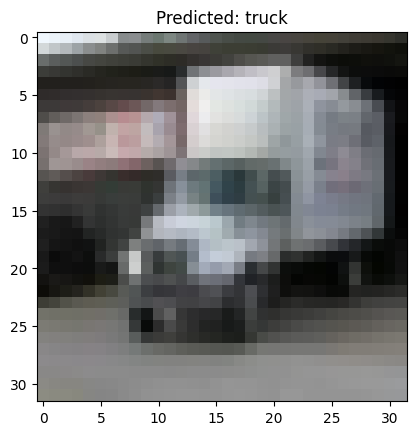

In [73]:
n = get_watch(OneMoreConv, optim.RMSprop, lr = 0.00004, epoch=5, normalize=True, scheduler=True)
visualize_result(getnum(), n)

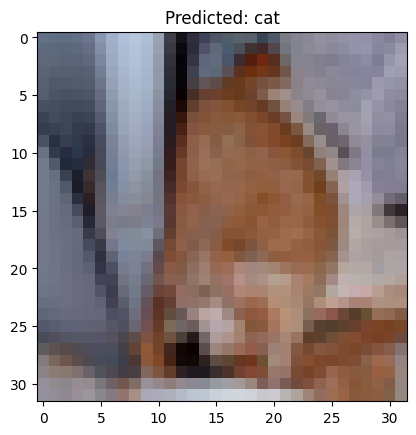

In [76]:
visualize_result(getnum(), n)